<a href="https://colab.research.google.com/github/estherakinniyi/AI_Baased_Chatbot/blob/main/AI_Based_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fintech Knowledge Copilot - Nigeria (RAG System)

This notebook demonstrates **Retrieval-Augmented Generation (RAG)** using internal policy documents from a Nigerian fintech company.

**Learning Objectives:**
- Understand how RAG works (retrieve relevant documents, then generate answers)
- See how embeddings enable semantic search
- Practice building a simple document Q&A system
- Learn about the importance of citations and source transparency

**One-Sentence Summary (Memorable)**
- *LLM*: A powerful language generator trained on massive text.
- *RAG*: A method that forces the LLM to answer using your verified data.

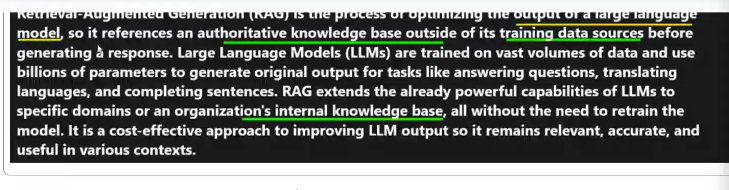

##Step 1 install required libraries

In [2]:
# Install required libraries (runs once per runtime)
!pip install -q transformers sentence-transformers torch

## Step 2: Mount Google Drive and Load Documents

**Before running this notebook:**
1. Download the `fintech_docs` folder (contains kyc_policy.txt, dispute_resolution.txt, product_faqs.txt)
2. Upload it to your Google Drive (e.g. `My Drive/fintech_docs`)
3. Run the cells below to mount Drive and load the documents

In [3]:
# Mount Google Drive so we can load the policy documents from your Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path to the fintech_docs folder in your Google Drive.
# Change this if you uploaded the folder to a different location.
# Example: "/content/drive/MyDrive/fintech_docs"
DOCS_DRIVE_PATH = "/content/drive/MyDrive/LLM21/fintech_docs"


In [5]:
import os
if os.path.exists(DOCS_DRIVE_PATH):
    print(f"Found docs folder at: {DOCS_DRIVE_PATH}")
    print("Files:", os.listdir(DOCS_DRIVE_PATH))
else:
    print("Folder not found! Please:")
    print("1. Download the fintech_docs folder (kyc_policy.txt, dispute_resolution.txt, product_faqs.txt)")
    print("2. Upload it to your Google Drive (e.g. My Drive/fintech_docs)")
    print("3. Update DOCS_DRIVE_PATH above if you used a different folder name or path")

Found docs folder at: /content/drive/MyDrive/LLM21/fintech_docs
Files: ['README.txt', 'kyc_policy.txt', 'product_faqs.txt', 'dispute_resolution.txt']


## Step 3: Load Documents and Split into Paragraphs

In [6]:
# This cell reads all .txt files from the docs folder (in your Drive) and splits each one
# into short paragraphs that we will use for retrieval.

from pathlib import Path
import os

# Use the Drive path from Step 2. Change if your folder is elsewhere.
DOCS_DIR = Path(DOCS_DRIVE_PATH)

def load_documents():
    docs = []
    for fname in os.listdir(DOCS_DIR):
        full_path = DOCS_DIR / fname
        if not full_path.is_file():
            continue

        with open(full_path, "r", encoding="utf-8") as f:
            text = f.read()

        # Split on blank lines to get paragraphs.
        paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]

        for idx, para in enumerate(paragraphs):
            docs.append(
                {
                    "filename": fname,
                    "paragraph_index": idx,
                    "text": para,
                }
            )
    return docs

if not DOCS_DIR.exists():
    print("ERROR: Docs folder not found at", DOCS_DRIVE_PATH)
    print("Please upload the fintech_docs folder to your Google Drive and update DOCS_DRIVE_PATH in Step 2.")
else:
    docs = load_documents()
    print(f"Loaded {len(docs)} paragraphs from {DOCS_DIR}")
    docs[:3]  # Show first few paragraphs as a sample

Loaded 34 paragraphs from /content/drive/MyDrive/LLM21/fintech_docs


## Step 4: Load Embedding Model and FLAN-T5

In [7]:
# This cell loads:
# - a sentence embedding model for retrieval (MiniLM)
# - the FLAN-T5-small model for generation

from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

embed_model_name = "sentence-transformers/all-MiniLM-L6-v2"
gen_model_name = "google/flan-t5-small"

embedder = SentenceTransformer(embed_model_name)
tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_model.to(device)

print("Embedding model:", embed_model_name)
print("Generation model:", gen_model_name)
print("Device:", device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/190 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Embedding model: sentence-transformers/all-MiniLM-L6-v2
Generation model: google/flan-t5-small
Device: cpu


## Step 5: Build Embeddings and Define RAG Functions

In [8]:
# This cell builds embeddings for all paragraphs and defines helper functions
# for retrieval and answer generation.

import torch

# Encode all paragraph texts into vectors once.
paragraph_texts = [d["text"] for d in docs]
paragraph_embeddings = embedder.encode(paragraph_texts, convert_to_tensor=True)

print("Built paragraph embeddings with shape:", paragraph_embeddings.shape)

def retrieve_context(query: str, top_k: int = 3):
    """
    Given a question string, find the top_k most similar paragraphs.
    """
    # Embed the question into the same vector space.
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # Compute cosine similarity between question and each paragraph.
    scores = util.cos_sim(query_embedding, paragraph_embeddings)[0]

    # Get indices of the best-matching paragraphs.
    top_indices = torch.topk(scores, k=min(top_k, len(docs))).indices.tolist()

    # Collect paragraphs with scores.
    retrieved = []
    for idx in top_indices:
        item = docs[idx].copy()
        item["score"] = float(scores[idx])
        retrieved.append(item)
    return retrieved


def generate_answer_from_context(question: str, retrieved_paragraphs):
    """
    Use FLAN-T5 to answer the question based only on the retrieved paragraphs.
    """
    # Join the retrieved paragraphs into one context string, tagging with filenames.
    context_lines = []
    for para in retrieved_paragraphs:
        context_lines.append(f"[{para['filename']}] {para['text']}")
    context_text = "\n\n".join(context_lines)

    # Build the instruction prompt for the model.
    prompt = (
        "You are a compliance and operations assistant at a Nigerian fintech company. "
        "You receive internal policy documents as context. "
        "Answer the employee's question ONLY using the information in the context. "
        "If the answer is not clearly in the context, say you do not know and "
        "recommend contacting the compliance team.\n\n"
        f"Context:\n{context_text}\n\n"
        f"Question: {question}\n\n"
        "Answer in simple English for a non-technical employee:"
    )

    # Tokenize the prompt and move it to the correct device.
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=768,
        truncation=True,
    ).to(device)

    # T5/FLAN-T5 needs decoder_start_token_id and pad_token_id for reliable generation.
    # Without these, the model can sometimes produce empty output.
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id

    # Ask the model to generate an answer.
    outputs = gen_model.generate(
        **inputs,
        max_new_tokens=200,
        min_length=5,
        decoder_start_token_id=tokenizer.pad_token_id,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
    )

    # Decode the generated tokens back to text.
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

    # Fallback if model returns empty (can happen with some transformer versions).
    if not answer or len(answer) < 3:
        answer = (
            "Based on the retrieved documents: "
            + retrieved_paragraphs[0]["text"][:300]
            + ("..." if len(retrieved_paragraphs[0]["text"]) > 300 else "")
        )
    return answer

Built paragraph embeddings with shape: torch.Size([34, 384])


## Step 6: Interactive Q&A Interface

In [9]:
# This cell creates a small question-answering interface using Colab widgets.
# The flow is:
# 1. User types a question.
# 2. We retrieve the top 3 relevant paragraphs.
# 3. We call FLAN-T5 to answer the question from those paragraphs.
# 4. We display the answer and the sources.

import ipywidgets as widgets
from IPython.display import display, Markdown

# Text box where the user types their question.
question_box = widgets.Textarea(
    value="What ID documents are required for Tier 2 wallets?",
    placeholder="Try: What are Tier 1 limits? How long for dispute refunds? How to fund wallet? What for chargebacks?",
    description="Question:",
    layout=widgets.Layout(width="100%", height="80px"),
    style={"description_width": "initial"},
)

# Button to run the retrieval and generation.
ask_button = widgets.Button(
    description="Ask the Fintech Copilot",
    button_style="primary",
)

# Output area where we will print the answer and sources.
output = widgets.Output()


def on_ask_button_clicked(b):
    with output:
        # Clear previous content (wait=True helps avoid flicker/empty display).
        output.clear_output(wait=True)

        question = question_box.value.strip()
        if not question:
            print("Please type a question first.")
            return

        print("Employee question:\n", question, "\n")

        # Step 1: retrieve top paragraphs.
        retrieved = retrieve_context(question, top_k=3)

        # Step 2: generate answer using FLAN-T5.
        print("Generating answer from retrieved context...\n")
        answer = generate_answer_from_context(question, retrieved)

        # Show the answer.
        display(Markdown("### Answer"))
        print(answer, "\n")

        # Show the sources so the user knows where information came from.
        display(Markdown("### Sources from internal documents"))
        for para in retrieved:
            print(
                f"- {para['filename']} (score={para['score']:.2f}), "
                f"paragraph {para['paragraph_index']}"
            )
            print(para["text"])
            print()

        print(
            "Note: This is an educational demo only and not legal advice. "
            "Always confirm important decisions with the compliance team."
        )


# Connect the button to the click handler.
ask_button.on_click(on_ask_button_clicked)

# Display the UI elements.
display(question_box, ask_button, output)


Textarea(value='What ID documents are required for Tier 2 wallets?', description='Question:', layout=Layout(he…

Button(button_style='primary', description='Ask the Fintech Copilot', style=ButtonStyle())

Output()

In [11]:
!pip install nbstripout
